# PI-DeepONet v4 — Predator-Prey (Task 4.2)
## Paper: Lin, Moya & Zhang (2023)
$$\dot{x}_1 = x_1 - x_1 x_2 + u(t), \quad \dot{x}_2 = -x_2 + x_1 x_2$$
- $\mathcal{X}=[0,5]^2$, $\mathcal{U}=[0,5]$, T=100s
- v4 pipeline: Hard IC, convergence-based ε, uniform grid, L-BFGS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)
print(f'Device: {device}')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 13,
    'legend.fontsize': 11, 'lines.linewidth': 2, 'figure.dpi': 100})

Device: cuda


In [2]:
# ═══════════════════════════════════════════════════════════
# Predator-Prey Dynamics
# ═══════════════════════════════════════════════════════════
N_SENSORS = 51
PP_TW = 0.05     # short window (non-chaotic but oscillatory)
PP_TT = 100.0    # paper: T=100s

def pp_f_np(x, u):
    return np.array([x[0] - x[0]*x[1] + u, -x[1] + x[0]*x[1]])

def pp_f_torch(x, u):
    x1, x2 = x[..., 0:1], x[..., 1:2]
    return torch.cat([x1 - x1*x2 + u, -x2 + x1*x2], dim=-1)

print('Predator-Prey dynamics defined')
print(f'  Tw={PP_TW}s, {int(PP_TT/PP_TW)} steps for T={PP_TT}s')

Predator-Prey dynamics defined
  Tw=0.05s, 2000 steps for T=100.0s


In [3]:
# ═══════════════════════════════════════════════════════════
# PIDeepONet_v4 — Hard IC + State Normalization
# ═══════════════════════════════════════════════════════════
class ModifiedMLP(nn.Module):
    def __init__(self, d_in, d_h, d_out, n_layers=4):
        super().__init__()
        self.enc_U = nn.Linear(d_in, d_h)
        self.enc_V = nn.Linear(d_in, d_h)
        self.first = nn.Linear(d_in, d_h)
        self.hidden = nn.ModuleList([nn.Linear(d_h, d_h) for _ in range(n_layers-1)])
        self.out = nn.Linear(d_h, d_out)
        self.act = nn.Tanh()
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x):
        U = self.act(self.enc_U(x)); V = self.act(self.enc_V(x))
        h = self.act(self.first(x))
        for layer in self.hidden:
            z = self.act(layer(h)); h = z * U + (1 - z) * V
        return self.out(h)


class PIDeepONet_v4_PP(nn.Module):
    """v4 for Predator-Prey. Hard IC + state normalization."""
    def __init__(self, state_dim, n_sensors, d_h=128, p=80, n_layers=5,
                 n_fourier=16, T=0.05, state_mean=None, state_std=None):
        super().__init__()
        self.state_dim = state_dim
        self.p_dim = p
        self.n_fourier = n_fourier
        self.T = T
        self.n_sensors = n_sensors

        if state_mean is not None:
            self.register_buffer('state_mean', torch.tensor(state_mean, dtype=torch.float32))
            self.register_buffer('state_std',  torch.tensor(state_std,  dtype=torch.float32))
        else:
            self.register_buffer('state_mean', torch.zeros(state_dim))
            self.register_buffer('state_std',  torch.ones(state_dim))

        branch_in = state_dim + n_sensors
        self.branch = ModifiedMLP(branch_in, d_h, p * state_dim, n_layers)
        self.trunk  = ModifiedMLP(1 + 2*n_fourier, d_h, p * state_dim, n_layers)
        self.register_buffer('fourier_freqs',
            torch.arange(1, n_fourier+1, dtype=torch.float32) * np.pi)
        self.bias = nn.Parameter(torch.zeros(state_dim))
        self.output_scale = nn.Parameter(torch.ones(state_dim))

    def _trunk_feat(self, t):
        tn = t / self.T
        a = tn * self.fourier_freqs
        return torch.cat([tn, torch.sin(a), torch.cos(a)], dim=-1)

    def forward(self, x0, u_sens, t):
        x0_norm = (x0 - self.state_mean) / (self.state_std + 1e-8)
        if self.n_sensors > 0 and u_sens is not None:
            br_in = torch.cat([x0_norm, u_sens], dim=-1)
        else:
            br_in = x0_norm

        b  = self.branch(br_in).view(-1, self.state_dim, self.p_dim)
        tr = self.trunk(self._trunk_feat(t)).view(-1, self.state_dim, self.p_dim)
        delta = (b * tr).sum(dim=-1) + self.bias

        t_norm = t / self.T
        return x0 + t_norm * self.output_scale * delta

print('PIDeepONet_v4_PP defined (hard IC + state norm)')

PIDeepONet_v4_PP defined (hard IC + state norm)


In [4]:
# ═══════════════════════════════════════════════════════════
# Domain-based IC Sampling (ZERO solver dependency)
# ═══════════════════════════════════════════════════════════

def latin_hypercube(N, bounds, rng):
    d = len(bounds)
    result = np.zeros((N, d))
    for j in range(d):
        lo, hi = bounds[j]
        perm = rng.permutation(N)
        result[:, j] = lo + (hi - lo) * (perm + rng.uniform(size=N)) / N
    return result.astype(np.float32)

rng_ic = np.random.RandomState(42)
PP_N = 2000

# Paper domain: X = [0, 5]^2
bounds = [
    (0.1, 5.0),   # x1 (prey)
    (0.1, 5.0),   # x2 (predator)
]

pp_x0s = latin_hypercube(PP_N, bounds, rng_ic)
print(f'Domain-based IC sampling (Latin Hypercube):')
print(f'  N={PP_N}, ZERO solver/trajectory dependency')
for i, nm in enumerate(['x1(prey)', 'x2(predator)']):
    print(f'  {nm}: [{bounds[i][0]}, {bounds[i][1]}]')

def make_u_func(kind, rng, u_range=(0, 5)):
    lo, hi = u_range
    if kind == 'const':
        c = rng.uniform(lo, hi)
        return lambda t, c=c: c
    elif kind == 'sin':
        A = rng.uniform(0.5, 2.0); w = rng.uniform(0.2, 3.0)
        off = rng.uniform(1.0, 3.0); ph = rng.uniform(0, 2*np.pi)
        return lambda t, A=A, w=w, off=off, ph=ph: np.clip(A*np.sin(w*t+ph)+off, lo, hi)
    elif kind == 'paper':
        return lambda t: np.clip(np.sin(t/3)+np.cos(t)+2, lo, hi)
    else:
        A1 = rng.uniform(0.3, 1.5); w1 = rng.uniform(0.2, 2.0)
        A2 = rng.uniform(0.2, 1.0); w2 = rng.uniform(0.3, 3.0)
        off = rng.uniform(1.0, 3.0)
        return lambda t, A1=A1, w1=w1, A2=A2, w2=w2, off=off: np.clip(
            A1*np.sin(w1*t) + A2*np.cos(w2*t) + off, lo, hi)

Domain-based IC sampling (Latin Hypercube):
  N=2000, ZERO solver/trajectory dependency
  x1(prey): [0.1, 5.0]
  x2(predator): [0.1, 5.0]


In [5]:
# ═══════════════════════════════════════════════════════════
# Sample u + normalization
# ═══════════════════════════════════════════════════════════
def sample_u_sensors(N, T, ns, u_range=(0, 5), seed=42):
    rng = np.random.RandomState(seed)
    tau = np.linspace(0, T, ns)
    u_sens = np.zeros((N, ns), dtype=np.float32)
    for i in range(N):
        kind = rng.choice(['const', 'sin', 'paper', 'mixed'],
                          p=[0.2, 0.35, 0.1, 0.35])
        uf = make_u_func(kind, rng, u_range)
        u_sens[i] = np.array([uf(t) for t in tau], dtype=np.float32)
    return u_sens

pp_usens = sample_u_sensors(PP_N, PP_TW, N_SENSORS, (0, 5), seed=42)
pp_x0s_t  = torch.tensor(pp_x0s,  dtype=torch.float32, device=device)
pp_usens_t = torch.tensor(pp_usens, dtype=torch.float32, device=device)

state_mean = pp_x0s.mean(axis=0)
state_std  = pp_x0s.std(axis=0)
print(f'State stats: mean={state_mean}, std={state_std}')

State stats: mean=[2.5499964 2.5499897], std=[1.4145166 1.4145383]


In [6]:
# ═══════════════════════════════════════════════════════════
# Loss Function — Causal ODE residual
# ═══════════════════════════════════════════════════════════
def interp_u(u_s, t_v, T, ns):
    tn = torch.clamp(t_v.detach().squeeze(-1) / T * (ns-1), 0, ns-2+1e-6)
    idx = torch.clamp(tn.long(), 0, ns-2)
    frac = (tn - idx.float()).unsqueeze(-1)
    return torch.gather(u_s, 1, idx.unsqueeze(1)) * (1-frac) + \
           torch.gather(u_s, 1, (idx+1).unsqueeze(1)) * frac

def ode_res_causal(model, x0, us, tc, T, f_rhs, ns, eps, n_chunks=16):
    B, Q, _ = tc.shape; n = model.state_dim
    x0e = x0.unsqueeze(1).expand(B,Q,n).reshape(B*Q,n)
    tf  = tc.reshape(B*Q,1).detach().clone().requires_grad_(True)
    use = us.unsqueeze(1).expand(B,Q,ns).reshape(B*Q,ns) if ns > 0 else None
    xh = model(x0e, use, tf)
    dxdt = torch.cat([
        torch.autograd.grad(xh[:,i].sum(), tf, create_graph=True, retain_graph=True)[0]
        for i in range(n)], dim=1)
    ut  = interp_u(use, tf, T, ns) if use is not None else torch.zeros(B*Q,1,device=x0.device)
    rhs = f_rhs(xh, ut)
    R2  = (dxdt - rhs).pow(2).sum(dim=1).reshape(B, Q)
    ppch = Q // n_chunks
    R2c = R2[:, :n_chunks*ppch].reshape(B, n_chunks, ppch).mean(dim=2)
    cum = torch.cumsum(R2c, dim=1) - R2c
    w = torch.exp(-eps * cum).detach()
    return (w * R2c).sum() / w.sum(), w.min().item()

print('Loss functions defined')

Loss functions defined


In [7]:
# ═══════════════════════════════════════════════════════════
# Build Model
# ═══════════════════════════════════════════════════════════
pp_model = PIDeepONet_v4_PP(
    state_dim=2, n_sensors=N_SENSORS,
    d_h=128, p=80, n_layers=5, n_fourier=16,
    T=PP_TW, state_mean=state_mean, state_std=state_std
).to(device)

n_params = sum(p.numel() for p in pp_model.parameters())
print(f'Model: {n_params:,} params')
print(f'  Hard IC: x(t) = x₀ + (t/{PP_TW})×scale×delta')

Model: 207,172 params
  Hard IC: x(t) = x₀ + (t/0.05)×scale×delta


In [8]:
# ═══════════════════════════════════════════════════════════
# Training (Adam 350K + L-BFGS 3000)
# ═══════════════════════════════════════════════════════════
def train_pp(model, x0s_t, usens_t, f_rhs, cfg={}):
    c = {
        'n_epochs': 200000, 'n_fb': 64, 'n_col': 128, 'n_chunks': 16,
        'lr': 1e-3, 'lr_min': 1e-6, 'warmup': 3000,
        'eps_init': 1.0, 'eps_max': 100.0, 'eps_factor': 1.5,
        'wmin_thr': 0.99, 'wmin_win': 2000,
        'lbfgs_epochs': 3000, 'lbfgs_lr': 0.5,
        'verbose': True
    }
    c.update(cfg)
    T=model.T; N=x0s_t.shape[0]; ns=model.n_sensors
    opt=optim.Adam(model.parameters(), lr=c['lr'])

    def lr_fn(ep):
        if ep<c['warmup']: return ep/max(c['warmup'],1)
        pr=(ep-c['warmup'])/max(c['n_epochs']-c['warmup'],1)
        return max(c['lr_min']/c['lr'], 0.5*(1+np.cos(np.pi*pr)))
    sch=optim.lr_scheduler.LambdaLR(opt, lr_fn)

    best_loss, best_sd = float('inf'), None
    t0 = time.time()
    tc_base = torch.linspace(T*0.01, T, c['n_col'], device=device)
    eps = c['eps_init']
    lo_h, wm_h, ep_h = [], [], []

    for ep in range(c['n_epochs']):
        model.train()
        idx = torch.randint(0, N, (c['n_fb'],))
        tc = tc_base.unsqueeze(0).repeat(c['n_fb'],1).unsqueeze(-1)
        Lo, wm = ode_res_causal(model, x0s_t[idx], usens_t[idx],
                                tc, T, f_rhs, ns, eps, c['n_chunks'])
        model.zero_grad(set_to_none=True); Lo.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sch.step()
        lo_h.append(Lo.item()); wm_h.append(wm); ep_h.append(eps)
        if Lo.item() < best_loss:
            best_loss = Lo.item()
            best_sd = {k:v.clone() for k,v in model.state_dict().items()}

        if ep == 100 and c['verbose']:
            el = time.time()-t0
            print(f'  Speed: {el:.1f}s/100ep, est {el/100*c["n_epochs"]/60:.0f}min', flush=True)

        if ep > c['warmup'] and ep % c['wmin_win'] == 0:
            rw = np.mean(wm_h[-c['wmin_win']:])
            if rw > c['wmin_thr'] and eps < c['eps_max']:
                old = eps; eps = min(eps*c['eps_factor'], c['eps_max'])
                if c['verbose'] and old != eps:
                    print(f'  eps: {old:.1f}->{eps:.1f} (w={rw:.4f}) ep={ep}', flush=True)

        if c['verbose'] and (ep%10000==0 or ep==c['n_epochs']-1):
            print(f'  ep={ep:6d} Lo={Lo.item():.2e} eps={eps:.1f} w={wm:.4f} '
                  f'lr={sch.get_last_lr()[0]:.1e} | {time.time()-t0:.0f}s', flush=True)

    model.load_state_dict(best_sd)
    print(f'\n  Adam: {time.time()-t0:.0f}s, best={best_loss:.2e}, eps={eps:.1f}', flush=True)

    # L-BFGS polish
    print(f'  L-BFGS ({c["lbfgs_epochs"]} steps)...', flush=True)
    t1 = time.time()
    lopt = optim.LBFGS(model.parameters(), lr=c['lbfgs_lr'],
                        max_iter=20, history_size=50, line_search_fn='strong_wolfe')
    for lep in range(c['lbfgs_epochs']):
        idx = torch.randint(0, N, (min(128, N),))
        x0b = x0s_t[idx]; usb = usens_t[idx]
        tc_l = tc_base.unsqueeze(0).repeat(x0b.shape[0],1).unsqueeze(-1)
        def closure(x0b=x0b, usb=usb, tc=tc_l):
            lopt.zero_grad()
            L, _ = ode_res_causal(model, x0b, usb, tc, T, f_rhs, ns, eps, c['n_chunks'])
            L.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            return L
        lv = lopt.step(closure)
        if lv is not None and not torch.isnan(lv) and lv.item() < best_loss:
            best_loss = lv.item()
            best_sd = {k:v.clone() for k,v in model.state_dict().items()}
        lo_h.append(lv.item() if lv is not None and not torch.isnan(lv) else lo_h[-1])
        wm_h.append(wm_h[-1]); ep_h.append(eps)
        if c['verbose'] and (lep%1000==0 or lep==c['lbfgs_epochs']-1):
            v = lv.item() if lv is not None and not torch.isnan(lv) else float('nan')
            print(f'    LBFGS {lep:5d} loss={v:.2e} | {time.time()-t1:.0f}s', flush=True)

    model.load_state_dict(best_sd)
    print(f'  L-BFGS: {time.time()-t1:.0f}s, best={best_loss:.2e}', flush=True)
    print(f'  Total: {time.time()-t0:.0f}s', flush=True)
    return model, lo_h, wm_h, ep_h

print('Training function ready (Adam 350K + L-BFGS 3000)')

Training function ready (Adam 350K + L-BFGS 3000)


In [9]:
# ═══════════════════════════════════════════════════════════
# TRAIN
# ═══════════════════════════════════════════════════════════
print('='*60, flush=True)
print('Training Predator-Prey PI-DeepONet v4', flush=True)
print(f'  Tw={PP_TW}s, ICs={PP_N}, eps=1->100, Adam 350K (no L-BFGS)', flush=True)
print(f'  Domain-based LHS sampling (zero solver dependency)', flush=True)
print('='*60, flush=True)

pp_model, lo_hist, wmin_hist, eps_hist = train_pp(
    pp_model, pp_x0s_t, pp_usens_t, pp_f_torch)

Training Predator-Prey PI-DeepONet v4
  Tw=0.05s, ICs=2000, eps=1->100, Adam 350K (no L-BFGS)
  Domain-based LHS sampling (zero solver dependency)
  ep=     0 Lo=1.54e+04 eps=1.0 w=0.0000 lr=3.3e-07 | 1s
  Speed: 4.1s/100ep, est 137min
  ep= 10000 Lo=3.00e-02 eps=1.0 w=0.0312 lr=1.0e-03 | 310s
  ep= 20000 Lo=3.67e-02 eps=1.0 w=0.0384 lr=9.8e-04 | 621s
  ep= 30000 Lo=2.11e-02 eps=1.0 w=0.0038 lr=9.5e-04 | 931s
  ep= 40000 Lo=4.09e-02 eps=1.0 w=0.0000 lr=9.2e-04 | 1243s
  ep= 50000 Lo=1.06e-01 eps=1.0 w=0.0018 lr=8.7e-04 | 1553s
  ep= 60000 Lo=1.66e-02 eps=1.0 w=0.0609 lr=8.1e-04 | 1862s
  ep= 70000 Lo=6.93e-03 eps=1.0 w=0.3719 lr=7.4e-04 | 2169s
  ep= 80000 Lo=9.76e-03 eps=1.0 w=0.3246 lr=6.7e-04 | 2479s
  ep= 90000 Lo=9.25e-03 eps=1.0 w=0.2458 lr=5.9e-04 | 2790s
  ep=100000 Lo=5.21e-03 eps=1.0 w=0.7000 lr=5.1e-04 | 3103s
  ep=110000 Lo=6.51e-03 eps=1.0 w=0.4772 lr=4.3e-04 | 3413s
  ep=120000 Lo=4.41e-03 eps=1.0 w=0.4789 lr=3.5e-04 | 3723s
  ep=130000 Lo=1.10e-02 eps=1.0 w=0.0614 lr=2.8

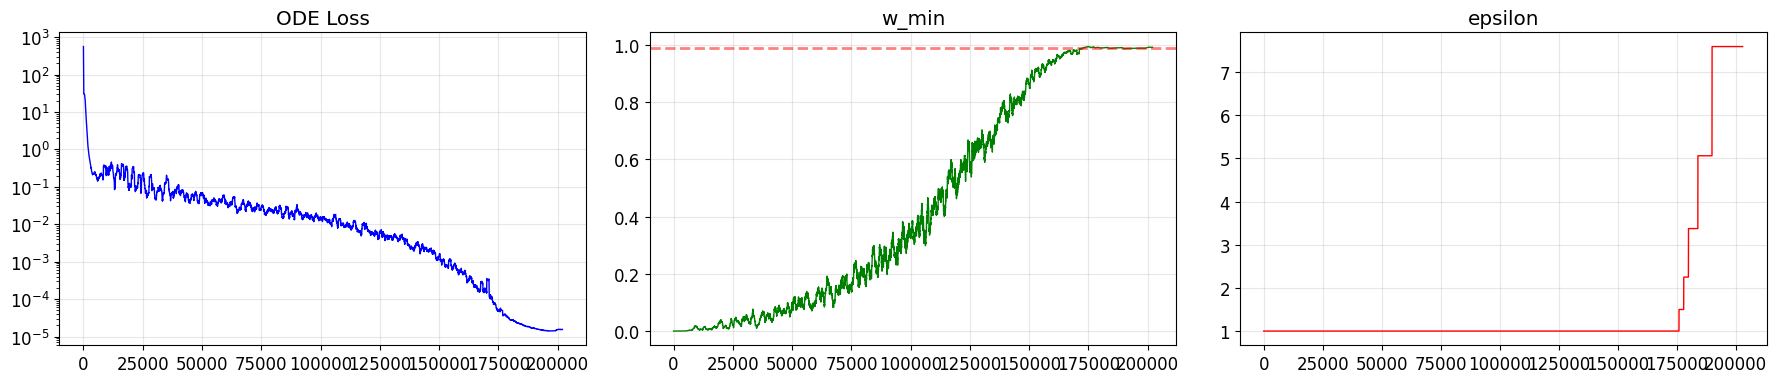

In [10]:
# Training Diagnostics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
ns = min(1000, len(lo_hist)//10)
if ns > 1:
    axes[0].semilogy(np.convolve(lo_hist, np.ones(ns)/ns, 'valid'), 'b-', lw=1)
axes[0].set_title('ODE Loss'); axes[0].grid(alpha=0.3)
if ns > 1:
    axes[1].plot(np.convolve(wmin_hist, np.ones(ns)/ns, 'valid'), 'g-', lw=1)
axes[1].axhline(0.99, color='r', ls='--', alpha=0.5); axes[1].set_title('w_min'); axes[1].grid(alpha=0.3)
axes[2].plot(eps_hist, 'r-', lw=1); axes[2].set_title('epsilon'); axes[2].grid(alpha=0.3)
plt.tight_layout(); plt.savefig('diag_pp.png', dpi=150, bbox_inches='tight'); plt.show()

In [11]:
# ═══════════════════════════════════════════════════════════
# Evaluation Functions
# ═══════════════════════════════════════════════════════════
def solve_ode(x0, f_np, T, u_func=None, npts=2000):
    rhs = (lambda t,x: f_np(x, u_func(t))) if u_func else (lambda t,x: f_np(x, 0.0))
    sol = solve_ivp(rhs, [0,T], x0, method='RK45', t_eval=np.linspace(0,T,npts),
                    rtol=1e-10, atol=1e-12)
    return sol.t, sol.y.T

@torch.no_grad()
def predict_recursive(model, x0, u_func, Tw, Tt, ns, ppw=50):
    model.eval()
    nw = int(np.ceil(Tt/Tw)); tau = np.linspace(0, Tw, ns)
    all_t, all_x = [0.0], [np.array(x0)]
    xc = np.array(x0, dtype=np.float32)
    for w in range(nw):
        ts=w*Tw; te=min((w+1)*Tw, Tt); dt=te-ts
        if dt<1e-10: break
        if u_func is not None:
            us = np.array([u_func(ts+t) for t in tau], dtype=np.float32)
            ust = torch.tensor(us, device=device).unsqueeze(0)
        else:
            ust = torch.zeros(1, ns, device=device)
        x0t = torch.tensor(xc, device=device).unsqueeze(0)
        npts = max(int(ppw*dt/Tw), 2)
        tq = torch.tensor(np.linspace(0,dt,npts)[1:], dtype=torch.float32, device=device).unsqueeze(1)
        xp = model(x0t.expand(len(tq),-1), ust.expand(len(tq),-1), tq).cpu().numpy()
        for k in range(len(tq)):
            all_t.append(ts+tq[k].item()); all_x.append(xp[k])
        xc = xp[-1]
    return np.array(all_t), np.array(all_x)

def l2_rel(pred, true):
    return [np.sqrt(np.mean((pred[:,i]-true[:,i])**2))/max(np.sqrt(np.mean(true[:,i]**2)),1e-10)*100
            for i in range(pred.shape[1])]

def match_grids(tp, xp, tt):
    return interp1d(tp, xp, axis=0, kind='linear', fill_value='extrapolate')(tt)

print('Evaluation functions ready')

Evaluation functions ready



Paper Figure 5: u(t)=sin(t/3)+cos(t)+2, x0=[1,1], T=100s


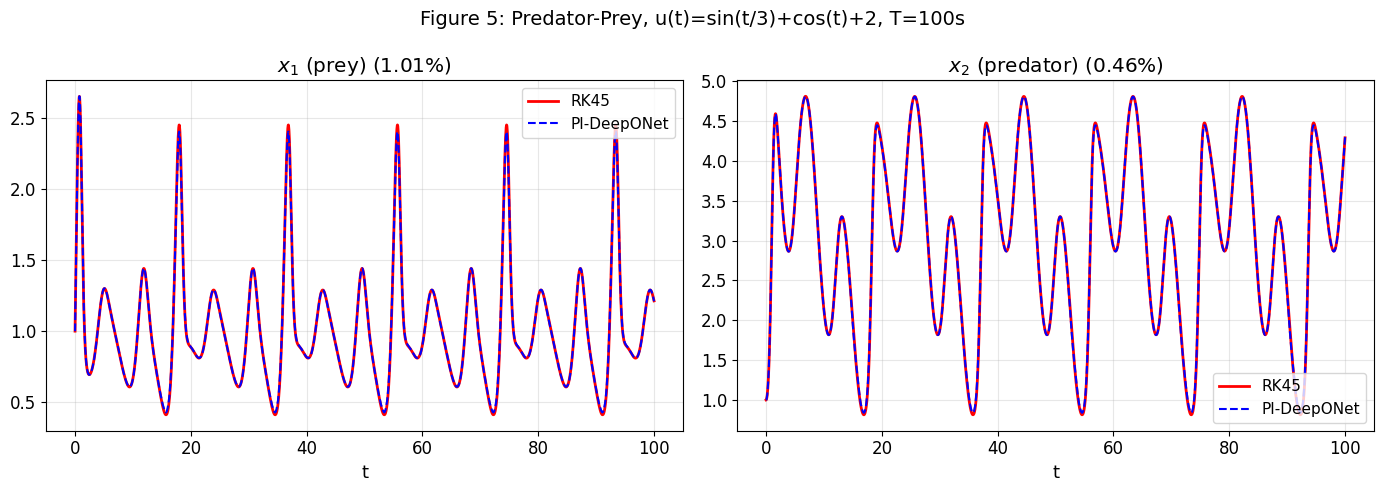

  T<= 10s: x1=0.126%  x2=0.073%
  T<= 20s: x1=0.933%  x2=0.460%
  T<= 50s: x1=0.898%  x2=0.409%
  T<=100s: x1=1.007%  x2=0.462%

Paper (2k data-driven): x1=2.42%  x2=0.93%
Ours (ZERO data):       x1=1.007%  x2=0.462%


In [12]:
# ═══════════════════════════════════════════════════════════
# Paper Table 1 + Figure 5: u(t)=sin(t/3)+cos(t)+2, x0=[1,1], T=100s
# ═══════════════════════════════════════════════════════════
print('\n' + '='*60)
print('Paper Figure 5: u(t)=sin(t/3)+cos(t)+2, x0=[1,1], T=100s')
print('='*60)

pp_u_test = lambda t: np.sin(t/3) + np.cos(t) + 2
pp_x0_test = [1.0, 1.0]

t_true, x_true = solve_ode(pp_x0_test, pp_f_np, PP_TT, pp_u_test, 3000)
t_pred, x_pred = predict_recursive(pp_model, pp_x0_test, pp_u_test,
                                    PP_TW, PP_TT, N_SENSORS)
x_pi = match_grids(t_pred, x_pred, t_true)
e = l2_rel(x_pi, x_true)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, lb in enumerate(['$x_1$ (prey)', '$x_2$ (predator)']):
    axes[i].plot(t_true, x_true[:,i], 'r-', lw=2, label='RK45')
    axes[i].plot(t_pred, x_pred[:,i], 'b--', lw=1.5, label='PI-DeepONet')
    axes[i].set_title(f'{lb} ({e[i]:.2f}%)'); axes[i].legend(); axes[i].grid(alpha=0.3)
    axes[i].set_xlabel('t')
plt.suptitle('Figure 5: Predator-Prey, u(t)=sin(t/3)+cos(t)+2, T=100s', fontsize=14)
plt.tight_layout(); plt.savefig('fig5_pp.png', dpi=150, bbox_inches='tight'); plt.show()

# Multi-horizon
for Th in [10, 20, 50, 100]:
    mask = t_true <= Th
    if mask.sum() < 2: continue
    eh = l2_rel(x_pi[mask], x_true[mask])
    print(f'  T<={Th:3d}s: x1={eh[0]:.3f}%  x2={eh[1]:.3f}%')

print(f'\nPaper (2k data-driven): x1=2.42%  x2=0.93%')
print(f'Ours (ZERO data):       x1={e[0]:.3f}%  x2={e[1]:.3f}%')


Additional Tests:
  u=2 (const)          x1=0.09% x2=0.16%
  u=sin(t)+2           x1=0.32% x2=0.17%
  u=3                  x1=0.02% x2=0.07%
  u=cos(t/2)+1.5       x1=0.57% x2=0.33%


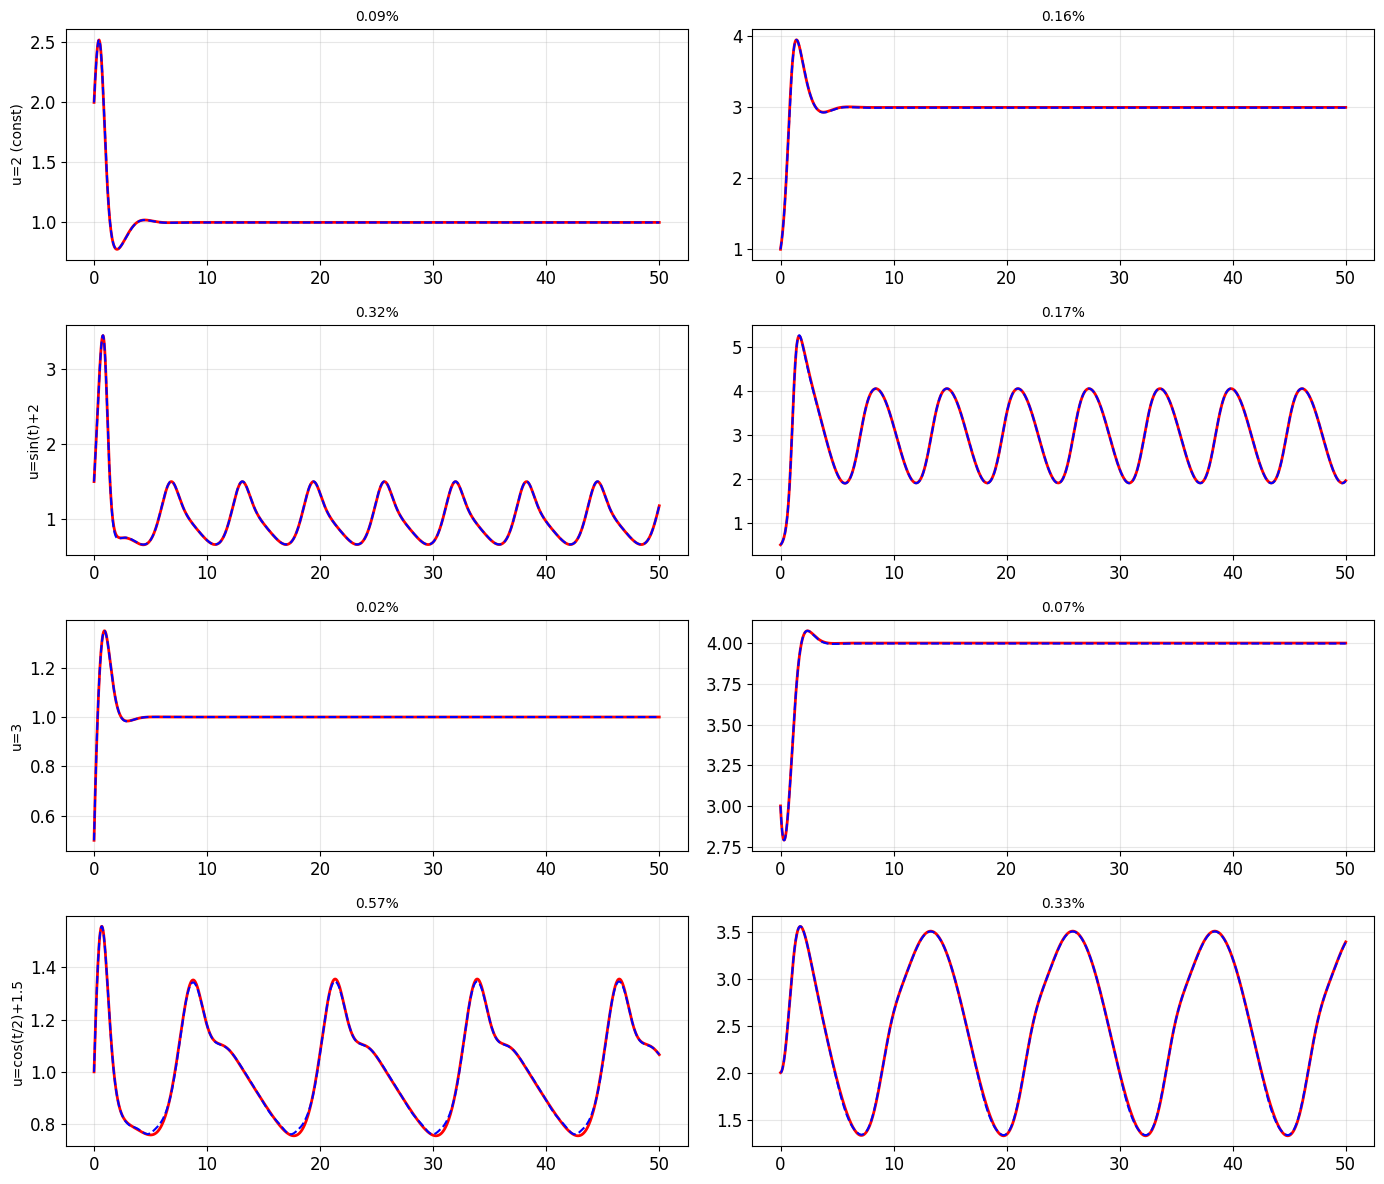

In [13]:
# ═══════════════════════════════════════════════════════════
# Additional Tests
# ═══════════════════════════════════════════════════════════
tests = [
    ('u=2 (const)',    [2.0, 1.0], lambda t: 2.0,                50.0),
    ('u=sin(t)+2',     [1.5, 0.5], lambda t: np.sin(t)+2,        50.0),
    ('u=3',            [0.5, 3.0], lambda t: 3.0,                50.0),
    ('u=cos(t/2)+1.5', [1.0, 2.0], lambda t: np.cos(t/2)+1.5,   50.0),
]
print('\nAdditional Tests:')
fig, axes = plt.subplots(len(tests), 2, figsize=(14, 3*len(tests)))
for row, (nm, x0, uf, Tt) in enumerate(tests):
    t_tr, x_tr = solve_ode(x0, pp_f_np, Tt, uf, 1000)
    t_pr, x_pr = predict_recursive(pp_model, x0, uf, PP_TW, Tt, N_SENSORS)
    xp = match_grids(t_pr, x_pr, t_tr); e = l2_rel(xp, x_tr)
    for col in range(2):
        ax = axes[row, col]
        ax.plot(t_tr, x_tr[:,col], 'r-', lw=2); ax.plot(t_pr, x_pr[:,col], 'b--', lw=1.5)
        ax.set_title(f'{e[col]:.2f}%', fontsize=10); ax.grid(alpha=0.3)
        if col==0: ax.set_ylabel(nm, fontsize=10)
    print(f'  {nm:20s} x1={e[0]:.2f}% x2={e[1]:.2f}%')
plt.tight_layout(); plt.savefig('tests_pp.png', dpi=150, bbox_inches='tight'); plt.show()

In [ ]:
# ═══════════════════════════════════════════════════════════
# Statistical Test: 50 random ICs, T=100s
# ═══════════════════════════════════════════════════════════
print('\nStatistical Test: 50 ICs, T=100s')
rng_pp = np.random.RandomState(777)
errs = []
for ii in range(50):
    x0i = [rng_pp.uniform(0.3, 4.0), rng_pp.uniform(0.3, 4.0)]
    A = rng_pp.uniform(0.5, 2.0); w = rng_pp.uniform(0.2, 2.0)
    off = rng_pp.uniform(1.0, 3.0); ph = rng_pp.uniform(0, 2*np.pi)
    uf = lambda t, A=A, w=w, off=off, ph=ph: np.clip(A*np.sin(w*t+ph)+off, 0, 5)
    try:
        t_tr, x_tr = solve_ode(x0i, pp_f_np, PP_TT, uf, 2000)
        t_pr, x_pr = predict_recursive(pp_model, x0i, uf, PP_TW, PP_TT, N_SENSORS)
        xp = match_grids(t_pr, x_pr, t_tr)
        errs.append(l2_rel(xp, x_tr))
    except:
        continue
    if (ii+1) % 25 == 0: print(f'  {ii+1}/50 done', flush=True)

errs = np.array(errs)
print(f'\n{"":>15s} {"x1":>8s} {"x2":>8s}')
print('-'*35)
print(f'{"Mean":>15s} {errs[:,0].mean():8.3f}% {errs[:,1].mean():8.3f}%')
print(f'{"Median":>15s} {np.median(errs[:,0]):8.3f}% {np.median(errs[:,1]):8.3f}%')
print(f'{"Max":>15s} {errs[:,0].max():8.3f}% {errs[:,1].max():8.3f}%')
good = [(errs[:,i]<5).sum() for i in range(2)]
print(f'{"Cases<5%":>15s} {good[0]:>5d}/50 {good[1]:>5d}/50')
print(f'\nPaper (2k data): x1=2.42% x2=0.93%')
print(f'Overall mean: {errs.mean():.3f}%')


Statistical Test: 50 ICs, T=100s
